## test projet marmitton 

In [1]:
from selenium import webdriver
import requests
from selenium.webdriver.chrome.options import Options as ChromeOptions

In [2]:
# Import necessary packages
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import requests

url = "https://www.marmiton.org/"
response = requests.get(url)

# Affiche les informations de la réponse
print(response.status_code)
print(type(response.content))
print(type(response.text))
# print(response.text) # Peut être très long, décommenter si nécessaire

# Écriture dans le fichier avec un context manager (plus sûr)
with open("marmiton.html", "w", encoding='utf-8') as create_file:
    create_file.write(response.text)

# Configuration de Chrome pour éviter les erreurs de session
chrome_options = Options()
chrome_options.add_argument("--disable-search-engine-choice-screen")

try:
    driver = webdriver.Chrome(options=chrome_options)
    driver.get("https://www.marmiton.org/")
    print("Navigateur lancé avec succès.")
except Exception as e:
    print(f"Erreur lors du lancement de Chrome : {e}")

SSLError: HTTPSConnectionPool(host='www.marmiton.org', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.marmiton.org'. (_ssl.c:1006)")))

In [3]:
from bs4 import BeautifulSoup

# Lecture du fichier marmiton.html généré précédemment
try:
    with open("marmiton.html", "r", encoding="utf-8") as f:
        html_content = f.read()
        html_content = open("marmiton.html", "r", encoding="utf-8").read()
        open("marmiton.html", "r", encoding="utf-8").read()
    
    soup = BeautifulSoup(html_content, 'html.parser')
    
    def extraire_titres(soup):
        # TODO: Implémenter l'extraction des titres de recettes
        pass

    def extraire_ingredients(soup):
        # TODO: Implémenter l'extraction des listes d'ingrédients
        pass

    def extraire_images(soup):
        # TODO: Implémenter la récupération des URLs des images
        pass

    # Exécution des fonctions de traitement
    extraire_titres(soup)
    extraire_ingredients(soup)
    extraire_images(soup)
    print("Fichier chargé et prêt pour l'analyse.")

except FileNotFoundError:
    print("Le fichier marmiton.html n'a pas été trouvé. Assurez-vous d'avoir exécuté la cellule précédente.")

Fichier chargé et prêt pour l'analyse.


Il faut chercher dans la page ce type de contenu pour avoir accès aux notes /5 de la recette. Il s'agit ici de "brioche_facile" 

url:  view-source:https://www.marmiton.org/recettes/recette_brioche-facile_27661.aspx


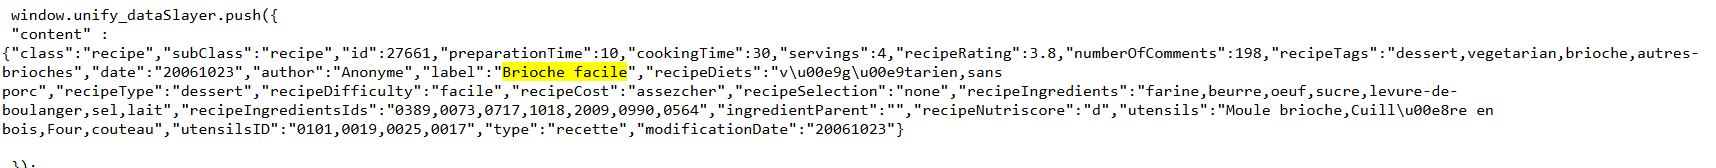

In [ ]:
import os

file_path = os.path.abspath("marmiton.html")
for 


In [19]:
import csv
import json

def extraire_liens_page(soup):
    """
    Fonction pour extraire tous les liens .aspx et https de la page.
    Retourne une liste de dictionnaires [{'titre_lien': ..., 'lien': ...}].
    Filtre les doublons d'URL.
    """
    liens_uniques = []
    urls_vues = set()

    # Utiliser soup.find_all('a') pour récupérer tous les liens
    liens = soup.find_all('a')
    
    # Boucle sur chaque lien
    for lien_tag in liens:
        # 1. Récupérer l'attribut 'href' et le texte du lien (titre).
        href = lien_tag.get('href')
        titre = lien_tag.get_text(strip=True)
        
        if href:
            # 2. Filtrer : Garder si 'href' contient ".aspx" OU commence par "https" (tous domaines).
            if ".aspx" in href or href.startswith("https"):
                
                # 3. Dédoublonnage
                if href not in urls_vues:
                    urls_vues.add(href)
                    liens_uniques.append({
                        'titre_lien': titre if titre else "Sans titre", # Gestion des titres vides
                        'lien': href
                    })
    
    return liens_uniques

def sauvegarder_donnees(donnees, nom_fichier, format_fichier='csv'):
    """
    Fonction pour sauvegarder les données extraites dans un fichier CSV ou JSON.
    Colonnes attendues : titres_lien, lien
    """
    if format_fichier == 'csv':
        colonnes = ['titre_lien', 'lien']
        try:
            with open(nom_fichier, 'w', encoding='utf-8', newline='') as f:
                writer = csv.DictWriter(f, fieldnames=colonnes)
                writer.writeheader()
                writer.writerows(donnees)
            print(f"Données sauvegardées avec succès dans {nom_fichier}")
        except Exception as e:
            print(f"Erreur lors de la sauvegarde CSV: {e}")
            
    elif format_fichier == 'json':
        try:
            with open(nom_fichier, 'w', encoding='utf-8') as f:
                json.dump(donnees, f, indent=4, ensure_ascii=False)
            print(f"Données sauvegardées avec succès dans {nom_fichier}")
        except Exception as e:
            print(f"Erreur lors de la sauvegarde JSON: {e}")
    else:
        print("Format non supporté.")

# Utilisation des fonctions
if 'soup' in globals() or 'soup' in locals():
    liens_extraits = extraire_liens_page(soup)
    print(f"{len(liens_extraits)} liens uniques trouvés.")
    
    if len(liens_extraits) > 0:
        print(f"Exemple de lien extrait : {liens_extraits[0]}")
        sauvegarder_donnees(liens_extraits, "liens_marmiton.csv", format_fichier='csv')
        sauvegarder_donnees(liens_extraits, "liens_marmiton.json", format_fichier='json')
else:
    print("Erreur : La variable 'soup' n'est pas définie. Veuillez exécuter la cellule précédente pour charger la page HTML.")

205 liens uniques trouvés.
Exemple de lien extrait : {'titre_lien': 'Sans titre', 'lien': 'https://www.marmiton.org/'}
Données sauvegardées avec succès dans liens_marmiton.csv
Données sauvegardées avec succès dans liens_marmiton.json


In [22]:
import time
import random
import requests
import re
from bs4 import BeautifulSoup
import json
import concurrent.futures # Nécessaire pour le parallélisme

# --- PHASE 1 : Récupération récursive (Crawling) ---
# Note : On garde le crawling séquentiel pour ne pas se faire bannir trop vite par le site
# car bombarder de requêtes différentes pages de navigation est suspect.

def crawling_recursif_categories(url_depart, urls_visitees, urls_recettes, profondeur_max=200, profondeur_actuelle=0, max_breadth=10):
    
    if profondeur_actuelle > profondeur_max: return
    if url_depart in urls_visitees: return

    urls_visitees.add(url_depart)
    indent = "  " * profondeur_actuelle
    print(f"{indent}📂 Niv {profondeur_actuelle}: {url_depart}")

    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
        response = requests.get(url_depart, headers=headers, timeout=10)
        
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            liens_page = soup.find_all('a')
            nb_recettes_trouvees = 0
            nouvelles_categories = []

            for link in liens_page:
                href = link.get('href')
                if not href: continue
                
                if href.startswith('/'): full_url = "https://www.marmiton.org" + href
                elif href.startswith('http'): full_url = href
                else: continue
                    
                full_url = full_url.split('#')[0]

                if '/recettes/recette_' in full_url:
                    if full_url not in urls_recettes:
                        urls_recettes.add(full_url)
                        nb_recettes_trouvees += 1
                
                elif ('/recettes/index/categorie/' in full_url or '/recettes/index/ingredient/' in full_url):
                    if full_url not in urls_visitees and full_url not in nouvelles_categories:
                        nouvelles_categories.append(full_url)
            
            print(f"{indent}   -> +{nb_recettes_trouvees} recettes (Total: {len(urls_recettes)})")
            
            # Appel récursif limité
            for sous_cat_url in nouvelles_categories[:max_breadth]:
                crawling_recursif_categories(sous_cat_url, urls_visitees, urls_recettes, profondeur_max, profondeur_actuelle + 1, max_breadth)

    except Exception as e:
        print(f"Erreur sur {url_depart} : {e}")

# --- PHASE 2 : Extraction des détails (Optimisée Multi-threading) ---

def extraire_details_recette(url_recette):
    details = { 'url': url_recette, 'titre': None, 'note': None, 'categorie_principale': None }
    try:
        # Pause légère aléatoire pour varier les timings même en parallèle
        time.sleep(random.uniform(0.1, 0.5)) 
        
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)'}
        response = requests.get(url_recette, headers=headers, timeout=10)
        
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            
            h1 = soup.find('h1')
            if h1: details['titre'] = h1.get_text(strip=True)
            
            note_elem = soup.find(string=re.compile(r'\d(\.\d)?/5'))
            if note_elem: details['note'] = note_elem.strip()
            
            categories_links = soup.find_all('a', href=lambda x: x and '/recettes/index/categorie/' in x)
            if categories_links: details['categorie_principale'] = categories_links[0].get_text(strip=True)
            
            return details # Succès
    except: 
        pass
    
    return details # Retourne au moins l'URL en cas d'échec


# --- EXECUTION ---

url_racine = "https://www.marmiton.org/"
urls_visitees_global = set()
urls_recettes_global = set()

print(f"🚀 1. Lancement du CRAWLER (Séquentiel pour l'exploration)...")
crawling_recursif_categories(
    url_depart=url_racine, 
    urls_visitees=urls_visitees_global, 
    urls_recettes=urls_recettes_global, 
    profondeur_max=200, 
    max_breadth=200
)

list_urls = list(urls_recettes_global)
print(f"\n✅ Crawling terminé. {len(list_urls)} recettes trouvées.")


print(f"\n🚀 2. Lancement du SCRAPING (Parallélisé - 10 workers)...")
dataset_final = []

# Utilisation d'un ThreadPoolExecutor pour paralléliser les requêtes
# max_workers=10 signifie 10 pages chargées simultanément
with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    # On soumet toutes les tâches
    futures = {executor.submit(extraire_details_recette, url): url for url in list_urls}
    
    count = 0
    total = len(list_urls)
    
    # On récupère les résultats au fur et à mesure
    for future in concurrent.futures.as_completed(futures):
        data = future.result()
        dataset_final.append(data)
        count += 1
        if count % 10 == 0:
            print(f"   Progression: {count}/{total} recettes...", end='\r')

# Sauvegarde
with open('dataset_marmiton_final.json', 'w', encoding='utf-8') as f:
    json.dump(dataset_final, f, indent=4, ensure_ascii=False)

print(f"\n\n💾 Tout est fini ! Données sauvegardées dans dataset_marmiton_final.json")

🚀 1. Lancement du CRAWLER (Séquentiel pour l'exploration)...
📂 Niv 0: https://www.marmiton.org/
   -> +72 recettes (Total: 72)
  📂 Niv 1: https://www.marmiton.org/recettes/index/categorie/entree/
     -> +40 recettes (Total: 112)
    📂 Niv 2: https://www.marmiton.org/recettes/index/categorie/plat-principal/
       -> +33 recettes (Total: 145)
      📂 Niv 3: https://www.marmiton.org/recettes/index/categorie/dessert/
         -> +35 recettes (Total: 180)
        📂 Niv 4: https://www.marmiton.org/recettes/index/categorie/boissons/
           -> +42 recettes (Total: 222)
          📂 Niv 5: https://www.marmiton.org/recettes/index/categorie/boissons-chaudes/
             -> +26 recettes (Total: 248)
            📂 Niv 6: https://www.marmiton.org/recettes/index/categorie/vin-chaud/
               -> +8 recettes (Total: 256)
              📂 Niv 7: https://www.marmiton.org/recettes/index/ingredient/chou-blanc
                 -> +54 recettes (Total: 310)
                📂 Niv 8: https://www.marm